Authors: Marcus Lerfdal and Håvard Brenne

RRT implementation. Obstacles are realized in a gridworld, where 500 grids mark obstacles. The robot is a point mass which can move in continous coordinates whitin the borders of the gridworld. 

The algorithm returns the first valid path which is within a threshold distance of the goal, or None if no such path has been found within the allowed iterations. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from IPython.display import display, clear_output
import time

class Gridworld:
    def __init__(self, size_x, size_y):
        self.size_x = size_x
        self.size_y = size_y
        self.grid = np.zeros((size_x, size_y))
        self.obstacle_percentage = 0.005
        self.obstacles = []
    def place_obstacles(self):
        #Draw two line obstacles
        self.obstacles = [[[100,500],[400,500]], [[600,620],[600,820]]]
        self.grid[500:501,100:400] = 1 # Covers 300 cells 
        self.grid[620:820, 600:601] = 1 # Covers 200 cells
    def place_obstacles_random(self):
        rand_grid = np.random.rand(self.size_x,self.size_y)
        self.grid[rand_grid<self.obstacle_percentage] = 1
    def get_random_free_position(self):
        free = False
        while(not free):
            rnd_pos = np.array([np.random.rand()*self.size_x, np.random.rand()*self.size_y])
            if self.grid[int(rnd_pos[0]), int(rnd_pos[1])] == 0:
                free = True
        return rnd_pos

class Node:
    def __init__(self, pos, parent=None):
        self.pos = pos
        self.parent = parent

def counter_clockwise(x1,x2,x3):
    return (x3[1]-x1[1]) * (x2[0]-x1[0]) > (x2[1]-x1[1]) * (x3[0]-x1[0])

def line_segment_intersect(x1_start,x1_end,x2_start,x2_end):
    return counter_clockwise(x1_start,x2_start,x2_end) != counter_clockwise(x1_end,x2_start,x2_end) and counter_clockwise(x1_start,x1_end,x2_start) != counter_clockwise(x1_start,x1_end,x2_end)

def obstacle_free(x_nearest, x_new, gridworld):
    for i in range(len(gridworld.obstacles)):
        if line_segment_intersect(gridworld.obstacles[i][0], gridworld.obstacles[i][1], x_nearest, x_new):
            return False
    return True

def find_nearest_node(node_tree, node):
    dist, i = node_tree.query(node.pos, k=1, p=2)
    return dist, i
def get_node_path_to_root(node):
    node_path = [node]
    while node_path[-1].parent is not None:
        node_path.append(node_path[-1].parent)
    return node_path


KeyboardInterrupt: 

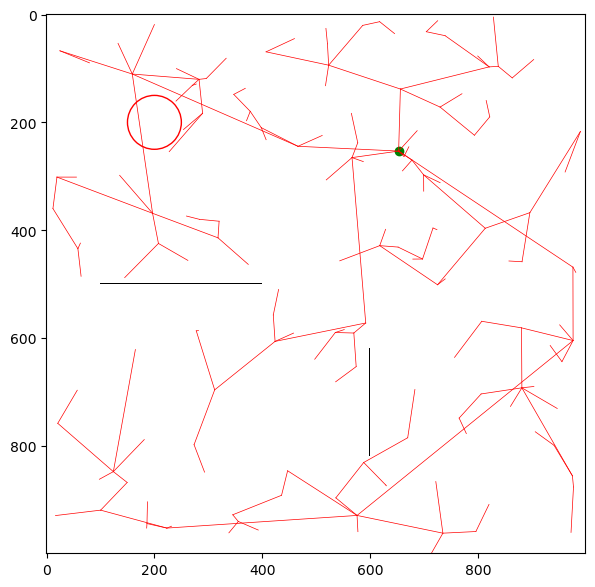

In [4]:
np.random.seed(0)

display_each_iteration = False

num_iterations = 50000
num_experiments = 10
goal_radius = 50
x_f = np.array([200,200])
gridworld = Gridworld(1000,1000)
gridworld.place_obstacles()

plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
    
for experiment in range(num_experiments): 
    x0 = gridworld.get_random_free_position()
    n0 = Node(x0)
    node_list = np.array([n0])
    
    plt.cla() 
    destination = plt.Circle((x_f[0], x_f[1]), goal_radius, color='r', fill=False)
    ax.add_patch(destination)
    plt.imshow(gridworld.grid, cmap='Greys')
    plt.plot(x0[0], x0[1], 'go')

    for i in range(num_iterations):
        node_tree = KDTree(np.array([n.pos for n in node_list]))
        rand_node = Node(gridworld.get_random_free_position())
        _, i = find_nearest_node(node_tree, rand_node)
        if obstacle_free(node_tree.data[i], rand_node.pos, gridworld):
            rand_node.parent = node_list[i]
            node_list = np.append(node_list, rand_node)
            
            plt.plot([rand_node.pos[0], node_list[i].pos[0]], [rand_node.pos[1], node_list[i].pos[1]], 'r-', linewidth=0.5)
            dist_to_goal = np.sqrt((x_f[0]-rand_node.pos[0])**2+(x_f[1]-rand_node.pos[1])**2)
        clear_output(wait = True)
        
        if dist_to_goal < goal_radius:
            path = get_node_path_to_root(rand_node)
            plt.plot([n.pos[0] for n in path], [n.pos[1] for n in path], 'g-', linewidth=1)
            display(fig)
            print("done",experiment)
            time.sleep(1)
            break
        
        if display_each_iteration or experiment==1 or experiment==6 or experiment==8:
            display(fig)
    time.sleep(1)
